Strategy: https://www.youtube.com/watch?v=Q0z2UTtgOtY

When obstacle detected, lunch a precomputed avoidance route, and call a* at the end

In [2]:
!pip install tdmclient --upgrade
!python -m tdmclient list

import time

import tdmclient.notebook
await tdmclient.notebook.list()
await tdmclient.notebook.start()

Defaulting to user installation because normal site-packages is not writeable


id:         87d48be9-2b09-4962-aab4-b8705c0cc9e7
group id:   1254e773-a221-45ca-b9a5-26e1f1bda390
product id: 8 (Thymio II)
name:       Super Thymio 474
status:     2 (available)
cap:        7
firmware:   14

id:       87d48be9-2b09-4962-aab4-b8705c0cc9e7
group id: 1254e773-a221-45ca-b9a5-26e1f1bda390
name:     Super Thymio 474
status:   2 (available)
cap:      7
firmware: 14



In [4]:
%%run_python

motor_left_target= 0 
motor_right_target= 0
leds_top = [0,0,0]
leds_bottom_left = [0,0,0]
leds_bottom_right = [0,0,0]  
leds_circle = [0,0,0,0,0,0,0,0]
nf_leds_top(0,0,0) 
nf_leds_bottom_left(0,0,0) 
nf_leds_bottom_right(0,0,0) 
nf_leds_circle(0,0,0,0,0,0,0,0)
nf_leds_prox_h(0,0,0,0,0,0,0,0) 
nf_leds_prox_v(0,0)
nf_leds_buttons(0,0,0,0)
nf_leds_rc(0) 
nf_leds_temperature(0,0) 
nf_leds_sound(0) 
prox_horizontal = [0,0,0,0,0,0,0] 
nf_prox_comm_enable(False)


In [54]:
import matplotlib.pyplot as plt

In [57]:
%%run_python --clear-event-data

import clock

timer_period[0] = 200

@onevent
def timer0():
    global prox_horizontal
    emit("front", clock.seconds(), prox_horizontal[0], prox_horizontal[2], prox_horizontal[4])

Interrupted


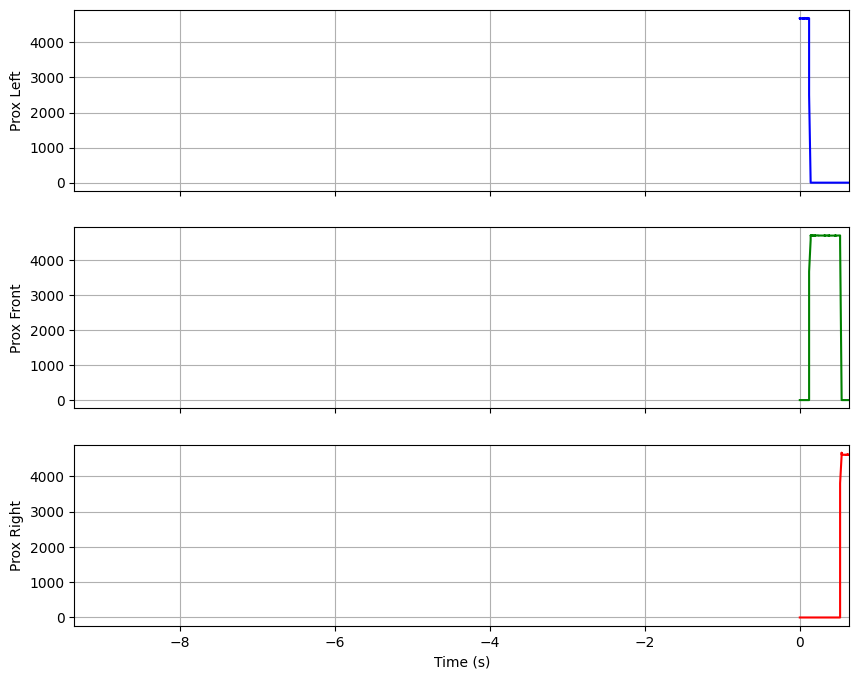

In [53]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

def update_plot(t, prox_left_values, prox_front_values, prox_right_values, time_span=10):
    clear_output(wait=True)
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

    if len(t) > 1:
        t_last = t[-1]
        xlim = (t_last - time_span, t_last)

        # Plot Proximity Left Sensor
        axes[0].plot(t, prox_left_values, color='blue')
        axes[0].set_xlim(xlim)
        axes[0].set_ylabel('Prox Left')
        axes[0].grid(True)

        # Plot Proximity Front Sensor
        axes[1].plot(t, prox_front_values, color='green')
        axes[1].set_xlim(xlim)
        axes[1].set_ylabel('Prox Front')
        axes[1].grid(True)

        # Plot Proximity Right Sensor
        axes[2].plot(t, prox_right_values, color='red')
        axes[2].set_xlim(xlim)
        axes[2].set_ylabel('Prox Right')
        axes[2].set_xlabel('Time (s)')
        axes[2].grid(True)

    plt.tight_layout()
    plt.show()

def on_event_data(node, event_name):
    data_list = get_event_data(event_name)
    t = [data[0] / 50 for data in data_list]  # Convert ticks to seconds
    prox_left_values = [data[1] for data in data_list]
    prox_front_values = [data[2] for data in data_list]
    prox_right_values = [data[3] for data in data_list]

    update_plot(t, prox_left_values, prox_front_values, prox_right_values)

clear_event_data()
tdmclient.notebook.process_events(on_event_data)

In [ ]:
%%run_python --wait

import clock

PROX_FARLEFT = 0
PROX_LEFT = 1
PROX_FRONT = 2
PROX_RIGHT = 3
PROX_FARRIGHT = 4

timer_period[0] = 100
avoiding_left = False
avoiding_right = False
avoiding_stage = 0
start_time = 0
end_time = 0
current_time = 0

prox_threshold = 3000
speed = 150
speed_factor = 1.5
T_TURN = 110
T_DRIVE = 390
VERBOSE = True

@onevent
def timer0():
    global prox_horizontal, motor_left_target, motor_right_target, speed, speed_factor, prox_threshold, start_time, end_time, current_time
    global avoiding_left, avoiding_right, avoiding_stage, PROX_FARLEFT, PROX_LEFT, PROX_FRONT, PROX_RIGHT, PROX_FARRIGHT, T_TURN, T_DRIVE, VERBOSE

    current_time = clock.ticks_50Hz()
    if VERBOSE:
        print(current_time, start_time)
    if avoiding_left or avoiding_right:
        if avoiding_left:
            if avoiding_stage == 1:
                if VERBOSE:
                    print("inside stage 1 (left)", current_time, start_time, current_time - start_time) 
                motor_left_target = -speed
                motor_right_target = speed
                if current_time - start_time > T_TURN:
                    if VERBOSE:
                        print("Finished stage 1 (left)")
                    avoiding_stage = 2
                    start_time = clock.ticks_50Hz() # 0?
                    current_time = 0
                    motor_left_target = 0
                    motor_right_target = 0
            if avoiding_stage == 2:
                if VERBOSE:
                    print("inside stage 2 (left)", current_time - start_time, current_time - start_time)
                motor_left_target = speed_factor * speed
                motor_right_target = speed
                if current_time - start_time > T_DRIVE:
                    if VERBOSE:
                        print("Finished stage 2 (right")
                    avoiding_stage = 0
                    avoiding_left = False
                    motor_left_target = 0
                    motor_right_target = 0
        else:
            if avoiding_stage == 1:
                if VERBOSE:
                    print("inside stage 1 (right)", current_time, start_time, current_time - start_time) 
                motor_left_target = speed
                motor_right_target = -speed
                if current_time - start_time > T_TURN:
                    if VERBOSE:
                        print("Finished stage 1 (right)")
                    avoiding_stage = 2
                    start_time = clock.ticks_50Hz()
                    motor_left_target = 0
                    motor_right_target = 0
            if avoiding_stage == 2:
                if VERBOSE:
                    print("inside stage 2 (right)", current_time - start_time, current_time - start_time)
                motor_left_target = speed
                motor_right_target = speed_factor * speed
                if current_time - start_time > T_DRIVE:
                    if VERBOSE:
                        print("Finished stage 2 (right")
                    avoiding_stage = 0
                    avoiding_right = False
                    motor_left_target = 0
                    motor_right_target = 0
    else:
        prox_farleft = prox_horizontal[PROX_FARLEFT]
        prox_left = prox_horizontal[PROX_LEFT]
        prox_front = prox_horizontal[PROX_FRONT]
        prox_right = prox_horizontal[PROX_RIGHT]
        prox_farright = prox_horizontal[PROX_FARRIGHT]

        p_sum = prox_farleft + prox_left + prox_front + prox_right + prox_farright
        
        if p_sum > prox_threshold:
            if prox_farleft + prox_left + prox_front >= prox_farright + prox_right + prox_front:
                avoiding_right = True
                avoiding_stage = 1
                start_time = clock.ticks_50Hz()
            else:
                avoiding_left = True
                avoiding_stage = 1
                start_time = clock.ticks_50Hz()

In [ ]:
from tdmclient import ClientAsync
import time

# Define proximity sensor indices
PROX_FARLEFT = 0
PROX_LEFT = 1
PROX_FRONT = 2
PROX_RIGHT = 3
PROX_FARRIGHT = 4

with ClientAsync() as client:
    async def prog():
        node = await client.wait_for_node()
        await node.lock()
        await node.wait_for_variables({"prox.horizontal"})
        await node.wait_for_variables({"motor.left.target"})
        await node.wait_for_variables({"motor.right.target"})
        
        speed = 100
        speed_factor = 2
        prox_threshold = 3000
        avoiding_left = False
        avoiding_right = False
        avoiding_stage = 0
        start_time = None  # Use None to indicate that timing hasn't started

        T_TURN = 2.0    # Duration of turning stage in seconds
        T_DRIVE = 8  # Duration of driving stage in seconds
        VERBOSE = True

        try:
            while True:
                current_time = time.time()
                # Read proximity sensor values
                prox_horizontal = node.v.prox.horizontal
                
                prox_farleft = prox_horizontal[PROX_FARLEFT]
                prox_left = prox_horizontal[PROX_LEFT]
                prox_front = prox_horizontal[PROX_FRONT]
                prox_right = prox_horizontal[PROX_RIGHT]
                prox_farright = prox_horizontal[PROX_FARRIGHT]

                if VERBOSE:
                    print(prox_farleft, prox_left, prox_front, prox_right, prox_farright)
                
                p_sum = prox_farleft + prox_left + prox_front + prox_right + prox_farright

                #if VERBOSE:
                #    print(f"Current time: {current_time}, Start time: {start_time}")

                if avoiding_left or avoiding_right:
                    if avoiding_left:
                        if avoiding_stage == 1:
                            if VERBOSE:
                                print("Inside stage 1 left", current_time, start_time, current_time - start_time)
                            node.v.motor.left.target = -speed
                            node.v.motor.right.target = speed

                            if current_time - start_time > T_TURN:
                                if VERBOSE:
                                    print("Finished stage 1 left", current_time, start_time, current_time - start_time)
                                avoiding_stage = 2
                                start_time = time.time()
                                node.v.motor.left.target = 0
                                node.v.motor.right.target = 0
                        
                        if avoiding_stage == 2:
                            if VERBOSE:
                                print("Inside stage 2 left", current_time, start_time, current_time - start_time)
                            node.v.motor.left.target = int(speed_factor * speed)
                            node.v.motor.right.target = speed

                            if current_time - start_time > T_DRIVE:
                                if VERBOSE:
                                    print("Finished stage 2 left", current_time, start_time, current_time - start_time)
                                avoiding_left = False
                                avoiding_stage = 0
                                node.v.motor.left.target = 0
                                node.v.motor.right.target = 0
                    else:
                        if avoiding_stage == 1:
                            if VERBOSE:
                                print("Inside stage 1 right", current_time, start_time)
                            node.v.motor.left.target = speed
                            node.v.motor.right.target = -speed

                            if current_time - start_time > T_TURN:
                                if VERBOSE:
                                        print("Finished stage 1 left", current_time, start_time)
                                avoiding_stage = 2
                                start_time = time.time()
                                node.v.motor.left.target = 0
                                node.v.motor.right.target = 0
                        
                        if avoiding_stage == 2:
                            if VERBOSE:
                                print("Inside stage 2 left", current_time, start_time)
                            node.v.motor.left.target =  speed
                            node.v.motor.right.target = int(speed_factor * speed)

                            if current_time - start_time > T_DRIVE:
                                if VERBOSE:
                                    print("Finished stage 2 left", current_time, start_time)
                                avoiding_right = False
                                avoiding_stage = 0
                                node.v.motor.left.target = 0
                                node.v.motor.right.target = 0

                else:
                    if p_sum > prox_threshold:
                        if prox_farleft + prox_left + prox_front >= prox_farright + prox_right + prox_front:
                            avoiding_right = True
                            avoiding_stage = 1
                            start_time = time.time()
                            if VERBOSE:
                                print("Obstacle detected on the left, starting avoidance to the left")
                        else:
                            avoiding_left = True
                            avoiding_stage = 1
                            start_time = time.time()
                            if VERBOSE:
                                print("Obstacle detected on the right, starting avoidance to the right")
                    else:
                        # No obstacles // follow a*
                        node.v.motor.left.target = 0
                        node.v.motor.right.target = 0

                node.flush()

                await client.sleep(0.001)

        finally:
            await node.unlock()

    client.run_async_program(prog)


In [1]:
from time import sleep
from tdmclient import ClientAsync, aw
client = ClientAsync()

In [2]:
client.process_waiting_messages()

True

In [3]:
node = client.nodes[0]

In [4]:
aw(node.lock())

Node 87d48be9-2b09-4962-aab4-b8705c0cc9e7

In [5]:
aw(node.unlock())

In [6]:
aw(node.lock())

Node 87d48be9-2b09-4962-aab4-b8705c0cc9e7

In [7]:
async def set_motors(speed_left, speed_right):
    speeds = {
        "motor.left.target": [speed_left],
        "motor.right.target": [speed_right],
    }
    await node.set_variables(speeds)

async def get_prox():
    await node.wait_for_variables({"prox.horizontal"})
    await client.sleep(0.05)
    return list(node.v.prox.horizontal)

In [9]:
await set_motors(0,0)

In [ ]:
import time

PROX_FARLEFT = 0
PROX_LEFT = 1
PROX_FRONT = 2
PROX_RIGHT = 3
PROX_FARRIGHT = 4

DETECTION_THRESHOLD = 3000
T_TURN = 0.5
T_DRIVE = 3.5

avoiding_left = False
avoiding_right = False
avoiding_stage = 0
speed = 100
start_time = 0
current_time = 0

while True:
    prox_values = await get_prox()
    prox_farleft = prox_values[PROX_FARLEFT]
    prox_left = prox_values[PROX_LEFT]
    prox_front = prox_values[PROX_FRONT]
    prox_right = prox_values[PROX_RIGHT]
    prox_farright = prox_values[PROX_FARRIGHT]

    current_time = time.time()
    
    if avoiding_left or avoiding_right:
        if avoiding_left:
            if avoiding_stage == 1:
                await set_motors(speed, -speed)
                if current_time - start_time > T_TURN:
                    avoiding_stage = 2
                    start_time = time.time()
                    await set_motors(0, 0)
            if avoiding_stage == 2:
                await set_motors(speed, speed)
                if current_time - start_time > T_DRIVE: 
                    avoiding_stage = 3
                    start_time = time.time()
                    await set_motors(0, 0)

            if avoiding_stage == 3:
                await set_motors(-speed, speed)
                if current_time - start_time > 6*T_TURN:
                    avoiding_stage = 4
                    start_time = time.time()
                    await set_motors(0,0)

            if avoiding_stage == 4:
                await set_motors(speed, speed)
                if current_time - start_time > T_DRIVE:
                    avoiding_stage = 0
                    avoiding_left = False
                    start_time = 0
                    await set_motors(0,0)
        else:
            if avoiding_stage == 1:
                await set_motors(-speed, speed)
                if current_time - start_time > T_TURN:
                    avoiding_stage = 2
                    start_time = time.time()
                    await set_motors(0, 0)
            if avoiding_stage == 2:
                await set_motors(speed, speed)
                if current_time - start_time > T_DRIVE: 
                    avoiding_stage = 3
                    start_time = time.time()
                    await set_motors(0, 0)

            if avoiding_stage == 3:
                await set_motors(speed, -speed)
                if current_time - start_time > 6*T_TURN:
                    avoiding_stage = 4
                    start_time = time.time()
                    await set_motors(0,0)

            if avoiding_stage == 4:
                await set_motors(speed, speed)
                if current_time - start_time > T_DRIVE:
                    avoiding_stage = 0
                    avoiding_right = False
                    start_time = 0
                    await set_motors(0,0)
            
    
    if prox_farleft + prox_left + prox_front + prox_right + prox_farright > DETECTION_THRESHOLD:
        if prox_farleft + prox_left + prox_front >= prox_farright + prox_right + prox_front:
            avoiding_left = True
            avoiding_stage = 1
            start_time = time.time()
        else:
            avoiding_right = True
            avoiding_stage = 1
            start_time = time.time()
            
    

In [1]:
from time import sleep
from tdmclient import ClientAsync, aw
client = ClientAsync()

In [2]:
client.process_waiting_messages()

True

In [3]:
node = client.nodes[0]

In [4]:
aw(node.lock())

Node 87d48be9-2b09-4962-aab4-b8705c0cc9e7

In [5]:
aw(node.unlock())

In [6]:
aw(node.lock())

Node 87d48be9-2b09-4962-aab4-b8705c0cc9e7

In [5]:
async def set_motors(speed_left, speed_right):
    speeds = {
        "motor.left.target": [speed_left],
        "motor.right.target": [speed_right],
    }
    await node.set_variables(speeds)

await set_motors(50, 50)

In [6]:
await set_motors(0, 0)

In [5]:
async def get_prox():
    await node.wait_for_variables({"prox.horizontal"})
    await client.sleep(0.05)
    return list(node.v.prox.horizontal)

# prox_values = await get_prox(node)

async def set_motors(speed_left, speed_right):
    #await node.wait_for_variables({"motor.left.target"})
    #await node.wait_for_variables({"motor.right.target"})
    speeds = {
        "motor.left.target": [speed_left],
        "motor.right.target": [speed_right],
    }
    await client.sleep(0.05)
    await node.set_variables(speeds)

In [6]:
await set_motors(50, 50)

In [4]:
prox_values = await get_prox()
prox_values

[0, 0, 0, 0, 0, 0, 0]

In [5]:
while True:
    await set_motors(50, 50)


CancelledError: 

In [ ]:
%%run_python --wait

import clock

PROX_FARLEFT = 0
PROX_LEFT = 1
PROX_FRONT = 2
PROX_RIGHT = 3
PROX_FARRIGHT = 4

timer_period[0] = 100
avoiding_left = False
avoiding_right = False
avoiding_stage = 0
start_time = 0
end_time = 0
current_time = 0

prox_threshold = 3000
speed = 150
speed_factor = 1.5
T_TURN = 110
T_DRIVE = 390
VERBOSE = True

@onevent
def timer0():
    global prox_horizontal, motor_left_target, motor_right_target, speed, speed_factor, prox_threshold, start_time, end_time, current_time
    global avoiding_left, avoiding_right, avoiding_stage, PROX_FARLEFT, PROX_LEFT, PROX_FRONT, PROX_RIGHT, PROX_FARRIGHT, T_TURN, T_DRIVE, VERBOSE

    current_time = clock.ticks_50Hz()
    if VERBOSE:
        print(current_time, start_time)
    if avoiding_left or avoiding_right:
        if avoiding_left:
            if avoiding_stage == 1:
                if VERBOSE:
                    print("inside stage 1 (left)", current_time, start_time, current_time - start_time) 
                motor_left_target = -speed
                motor_right_target = speed
                if current_time - start_time > T_TURN:
                    if VERBOSE:
                        print("Finished stage 1 (left)")
                    avoiding_stage = 2
                    start_time = clock.ticks_50Hz() # 0?
                    current_time = 0
                    motor_left_target = 0
                    motor_right_target = 0
            if avoiding_stage == 2:
                if VERBOSE:
                    print("inside stage 2 (left)", current_time - start_time, current_time - start_time)
                motor_left_target = speed_factor * speed
                motor_right_target = speed
                if current_time - start_time > T_DRIVE:
                    if VERBOSE:
                        print("Finished stage 2 (right")
                    avoiding_stage = 0
                    avoiding_left = False
                    motor_left_target = 0
                    motor_right_target = 0
        else:
            if avoiding_stage == 1:
                if VERBOSE:
                    print("inside stage 1 (right)", current_time, start_time, current_time - start_time) 
                motor_left_target = speed
                motor_right_target = -speed
                if current_time - start_time > T_TURN:
                    if VERBOSE:
                        print("Finished stage 1 (right)")
                    avoiding_stage = 2
                    start_time = clock.ticks_50Hz()
                    motor_left_target = 0
                    motor_right_target = 0
            if avoiding_stage == 2:
                if VERBOSE:
                    print("inside stage 2 (right)", current_time - start_time, current_time - start_time)
                motor_left_target = speed
                motor_right_target = speed_factor * speed
                if current_time - start_time > T_DRIVE:
                    if VERBOSE:
                        print("Finished stage 2 (right")
                    avoiding_stage = 0
                    avoiding_right = False
                    motor_left_target = 0
                    motor_right_target = 0
    else:
        prox_farleft = prox_horizontal[PROX_FARLEFT]
        prox_left = prox_horizontal[PROX_LEFT]
        prox_front = prox_horizontal[PROX_FRONT]
        prox_right = prox_horizontal[PROX_RIGHT]
        prox_farright = prox_horizontal[PROX_FARRIGHT]

        p_sum = prox_farleft + prox_left + prox_front + prox_right + prox_farright
        
        if p_sum > prox_threshold:
            if prox_farleft + prox_left + prox_front >= prox_farright + prox_right + prox_front:
                avoiding_right = True
                avoiding_stage = 1
                start_time = clock.ticks_50Hz()
            else:
                avoiding_left = True
                avoiding_stage = 1
                start_time = clock.ticks_50Hz()

In [62]:
speed = 100
start_time = time.time()
motor_left_target= -speed
motor_right_target= speed

In [63]:
print(prox_horizontal)
motor_left_target= 0
motor_right_target= 0
end_time = time.time()
turn_time = end_time - start_time # 2.0512993335723877

[0, 0, 0, 0, 0, 0, 0]


In [64]:
turn_time

1.1962268352508545

In [65]:
speed_factor = 2
start_time = time.time()
motor_left_target = speed * speed_factor
motor_right_target = speed

In [66]:
motor_left_target= 0
motor_right_target= 0
end_time = time.time()
travel_time = end_time - start_time # 2.0512993335723877
travel_time

5.176732063293457

In [17]:
start_time = time.time()
t_duration = 3
speed_factor = 3
t_elapsed = 0

while t_elapsed < t_duration:
    motor_left_target = speed * speed_factor
    motor_right_target = speed
    t_elapsed = time.time() - start_time

In [18]:
motor_left_target= 0
motor_right_target= 0

In [6]:
import time
from tdmclient import ClientAsync, aw

client = ClientAsync()
print(client.tdm_addr, client.tdm_port)

time.sleep(0.1)
print(client.process_waiting_messages())

time.sleep(0.1)
node = client.nodes[0]

127.0.0.1 8596
True


In [2]:
CONNECTED = 1
UNLOCKED = 2
BUSY = 3
LOCKED = 4
DISCONNECTED = 5

def get_status(node):
    status = node.status
    if status == CONNECTED:
        return "Connected"
    if status == UNLOCKED:
        return "Unlocked"
    if status == BUSY:
        return "Busy"
    if status == LOCKED:
        return "Locked"
    if status == DISCONNECTED:
        return "Disconnected"
    else:
        return "Unknown"

def lock_node(node):
    aw(node.lock())
    time.sleep(0.1)
    get_status(node)
               
def unlock_node(node):
    aw(node.unlock())
    time.sleep(0.1)
    get_status(node)

In [11]:
get_status(node)

'Locked'

In [4]:
lock_node(node)

aw(node.wait_for_variables({"motor.left.target"}))
aw(node.wait_for_variables({"motor.right.target"}))
aw(node.wait_for_variables({"prox.horizontal"}))

PROX_FARLEFT = 0
PROX_LEFT = 1
PROX_FRONT = 2
PROX_RIGHT = 3
PROX_FARRIGHT = 4
prox_threshold = 1000

speed = 50
def motors(speed_left, speed_right):
    return {
        "motor.left.target": [speed_left],
        "motor.right.target": [speed_right],
    }
    

In [8]:
start_time = time.time()
aw(node.set_variables(motors(-speed, speed)))


In [12]:
aw(node.set_variables(motors(0, 0)))
end_time = time.time()
turn_time = end_time - start_time

unlock_node(node)

In [1]:
from tdmclient import ClientAsync

def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

client = ClientAsync()

async def prog():
    node = await client.wait_for_node()
    await node.lock()
    await node.set_variables(motors(50, 50))
    await client.sleep(2)
    await node.set_variables(motors(0, 0))
    await node.unlock()

client.run_async_program(prog)

In [2]:
from tdmclient import ClientAsync

def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

with ClientAsync() as client:
    async def prog():
        with await client.lock() as node:
            await node.set_variables(motors(50, 50))
            await client.sleep(2)
            await node.set_variables(motors(0, 0))
    client.run_async_program(prog)

In [3]:
from tdmclient import ClientAsync

def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

def on_variables_changed(node, variables):
    try:
        prox = variables["prox.horizontal"]
        prox_front = prox[2]
        speed = -prox_front // 10
        node.send_set_variables(motors(speed, speed))
    except KeyError:
        pass  # prox.horizontal not found

with ClientAsync() as client:
    async def prog():
        with await client.lock() as node:
            await node.watch(variables=True)
            node.add_variables_changed_listener(on_variables_changed)
            await client.sleep()
    client.run_async_program(prog)

KeyboardInterrupt: 

In [ ]:
from tdmclient import ClientAsync

with ClientAsync() as client:
    async def prog():
        with await client.lock() as node:
            await node.wait_for_variables({"prox.horizontal"})
            while True:
                prox_front = node.v.prox.horizontal[2]
                speed = -prox_front // 10
                node.v.motor.left.target = speed
                node.v.motor.right.target = speed
                node.flush()
                await client.sleep(0.1)
    client.run_async_program(prog)